In [1]:
import torchvision.datasets as datasets
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

/users/ug20/advaitp/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# training_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
# test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

# training_dataset = datasets.CIFAR10(root="data/CIFAR10", train=True, download=True, transform=transforms.ToTensor())
# test_dataset = datasets.CIFAR10(root="data/CIFAR10", train=False, download=True, transform=transforms.ToTensor())

training_dataset = datasets.FashionMNIST(root="data/FashionMNIST", train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root="data/FashionMNIST", train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 14035655.71it/s]


Extracting data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 220283.43it/s]


Extracting data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4249887.63it/s]


Extracting data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15500557.78it/s]

Extracting data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/FashionMNIST/raw



In [3]:
image_shape = training_dataset.data[0].shape
if len(image_shape)==2:
  input_channels = 1
  input_dim = tuple(image_shape)
else:
  input_channels = image_shape[2]
  input_dim = tuple(image_shape[:-1])

In [4]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

In [5]:
class FeedForwardClassifier(torch.nn.Module):
    def __init__(self, output_dim, embed_size) -> None:
        super().__init__()
        self.fc1 = torch.nn.Linear(embed_size, 250)
        self.fc2 = torch.nn.Linear(250, output_dim)

    def forward(self, embedding):
        x = embedding.squeeze()
        x = torch.nn.ReLU()(self.fc1(x))
        output = self.fc2(x)
        return output

    def predict(self, embedding):
        logits = self.forward(embedding)
        probabilities = torch.nn.Softmax()(logits)
        return torch.argmax(probabilities, dim=1)

In [6]:
# Encoder and decoder use the DC-GAN architecture
class Encoder(torch.nn.Module):
    def __init__(self, z_dim, input_channels, input_dim):
        super(Encoder, self).__init__()
        self.input_channels = input_channels
        self.height, self.width = input_dim
        self.layer_height, self.layer_width = self.get_layer_size(2)
        self.model = torch.nn.ModuleList([
            torch.nn.Conv2d(
                in_channels=input_channels, 
                out_channels=64, 
                kernel_size=4, 
                stride=2, 
                padding=1
            ),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(
                in_channels=64, 
                out_channels=128, 
                kernel_size=4, 
                stride=2, 
                padding=1
            ),
            torch.nn.LeakyReLU(),
            Flatten(),
            torch.nn.Linear(128*self.layer_height*self.layer_width, 1024),
            torch.nn.LeakyReLU(),
        ])
        self.dense_mu = torch.nn.Linear(1024, z_dim)
        self.dense_logvar = torch.nn.Linear(1024, z_dim)
        
    def get_layer_size(self, layer_num):
        h = self.height
        w = self.width
        for _ in range(layer_num):
            h = int(h/2)
            w = int(w/2)
        return h, w
    
    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        mu = self.dense_mu(x)
        logvar = self.dense_logvar(x)
        return mu, logvar
    
    
class Decoder(torch.nn.Module):
    def __init__(self, z_dim, input_channels, input_dim):
        super(Decoder, self).__init__()
        self.input_channels = input_channels
        self.height, self.width = input_dim
        self.layer_height, self.layer_width = self.get_layer_size(2)
        self.model = torch.nn.ModuleList([
            torch.nn.Linear(z_dim, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, self.layer_height*self.layer_width*128),
            torch.nn.ReLU(),
            Reshape((128,self.layer_height,self.layer_width,)),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, input_channels, 4, 2, padding=1),
            torch.nn.Sigmoid()
        ])

    def get_layer_size(self, layer_num):
        h = self.height
        w = self.width
        for _ in range(layer_num):
            h = int(h/2)
            w = int(w/2)
        return h, w
        
    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x
    
class Model(torch.nn.Module):
    def __init__(self, z_dim, strategy, input_channels, input_dim):
        super(Model, self).__init__()
        self.encoder = Encoder(z_dim, input_channels, input_dim)
        self.decoder = Decoder(z_dim, input_channels, input_dim)
        self.strategy = strategy
        
    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std)

        if self.strategy=="Sampling":
            z = mu + eps * std
        elif self.strategy=="MAP":
            z = mu

        x_reconstructed = self.decoder(z)
        return z, x_reconstructed, mu, logvar

In [8]:
class Trainer:
    def __init__(self, train_loader, val_loader, model_type, sampling_strategy, num_samples, epochs, patience, delta, batch_size, embed_size, input_channels, input_dim):
        # Hyperparameters
        self.embed_size = embed_size
        self.input_channels = input_channels
        self.input_dim = input_dim
        self.batch_size = batch_size
        self.num_samples = num_samples
        self.epochs = epochs
        self.patience = patience
        self.delta = delta

        # Dataloader
        self.train_loader = train_loader
        self.val_loader = val_loader

        self.best_score = None
        self.num_bad_epochs = 0
        self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

        assert model_type=="VAE" or model_type=="MMD"
        self.model_type = model_type
    
        assert sampling_strategy=="Sampling" or sampling_strategy=="MAP"
        self.sampling_strategy = sampling_strategy

        # Model
        self.model = Model(z_dim=self.embed_size, strategy=self.sampling_strategy, input_channels=self.input_channels, input_dim=self.input_dim).to(self.DEVICE)

    def compute_kernel(self, x, y):
        x_size = x.size(0)
        y_size = y.size(0)
        dim = x.size(1)
        x = x.unsqueeze(1) # (x_size, 1, dim)
        y = y.unsqueeze(0) # (1, y_size, dim)
        tiled_x = x.expand(x_size, y_size, dim)
        tiled_y = y.expand(x_size, y_size, dim)
        kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
        return torch.exp(-kernel_input) # (x_size, y_size

    def compute_mmd(self, x, y):
        x_kernel = self.compute_kernel(x, x)
        y_kernel = self.compute_kernel(y, y)
        xy_kernel = self.compute_kernel(x, y)
        mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
        return mmd
    
    def early_stopping(self, fold):
        # Validation Loop
        val_loss = 0
        with torch.no_grad():
            for image, label in tqdm(self.val_loader):
                image = image.to(self.DEVICE)
                label = label.type(torch.LongTensor).to(self.DEVICE)

                true_samples =  torch.randn(self.num_samples, self.embed_size).to(self.DEVICE)
                embedding, out, mu, logvar = self.model.forward(image)

                mse_val_loss = torch.nn.functional.mse_loss(out, image)
                kl_val_loss = torch.mul(input=torch.sum(mu.pow(2) + logvar.exp() - logvar - 1), other=0.5)
                mmd_val_loss = self.compute_mmd(true_samples, embedding)

                if self.model_type=="VAE":
                    val_loss += (mse_val_loss + kl_val_loss)
                elif self.model_type=="MMD":
                    val_loss += (mse_val_loss + mmd_val_loss)
        
        # Early Stopping Condition
        if self.best_score == None:
            self.best_score = val_loss
            model_state_dict = self.model.state_dict()
            torch.save(model_state_dict, f"./weights/VAE/VAE_{fold}_weights.pt")
        elif self.best_score-val_loss>self.delta:
            self.best_score = val_loss
            model_state_dict = self.model.state_dict()
            self.num_bad_epochs = 0
            torch.save(model_state_dict, f"./weights/VAE/VAE_{fold}_weights.pt")
        else:
            self.num_bad_epochs += 1
        
        if self.num_bad_epochs==self.patience:
            return True, val_loss
        else:
            return False, val_loss
        
    def training(self, fold):
        self.optimizer = torch.optim.Adam(self.model.parameters())
        self.model.train()

        for epoch in range(self.epochs):
            # Training Loop
            epoch_loss = 0
            for image, label in tqdm(self.train_loader):
                self.optimizer.zero_grad()
                image = image.to(self.DEVICE)
                label = label.type(torch.LongTensor).to(self.DEVICE)

                # Passing the input image through VAE
                embedding, out, mu, logvar = self.model.forward(image)

                # Mean Square Error Loss (Reconstruction loss in VAE Loss function)
                mse_loss = torch.nn.functional.mse_loss(out, image)

                # Maximum Mean Discrepancy
                true_samples =  torch.randn(self.num_samples, self.embed_size).to(self.DEVICE)
                mmd = self.compute_mmd(true_samples, embedding)

                # KL-Divergence Loss (Regularization loss in VAE Loss function)
                kl_loss = torch.mul(input=torch.sum(mu.pow(2) + logvar.exp() - logvar - 1), other=0.5)

                # Total Loss Function
                if self.model_type=="VAE":
                    loss = mse_loss + kl_loss       # Reconstruction Loss + Regularization Loss
                elif self.model_type=="MMD":
                    loss = mse_loss + mmd           # Reconstruction Loss + Maximum Mean Discrepancy

                loss.backward() # Perform Back-Propogation
                self.optimizer.step() # Performs a single optimization step (parameter update)
                epoch_loss += loss
                del loss, out
                
            early_stopping, val_loss = self.early_stopping(fold)
            print(f'Epoch: {epoch}; Training Loss: {epoch_loss}; Validation Loss: {val_loss}')
            
            if early_stopping:
                print(f'Early Stopping at epoch {epoch}')
                break


In [9]:
class Classifier:
    def __init__(self, model, train_loader, val_loader, test_loader, epochs, num_classes, embed_size, delta, patience):
        self.training_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

        self.epochs = epochs
        self.num_classes = num_classes
        self.embed_size = embed_size
        self.delta = delta
        self.patience = patience
        self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

        self.model = model
        self.classifier = FeedForwardClassifier(output_dim=self.num_classes, embed_size=self.embed_size).to(self.DEVICE)

    def early_stopping(self, fold):
        # Validation Loop
        val_loss = 0
        with torch.no_grad():
            for image, label in tqdm(self.val_loader):
                image = image.to(self.DEVICE)
                label = label.type(torch.LongTensor).to(self.DEVICE)

                embedding, _, _, _ = self.model.forward(image)
                prediction = self.classifier.forward(embedding)
                classification_loss = torch.nn.CrossEntropyLoss()(prediction, label)
                val_loss += classification_loss
        
        # Early Stopping
        if self.best_score == None:
            self.best_score = val_loss
            classifier_state_dict = self.classifier.state_dict()
            torch.save(classifier_state_dict, f"./weights/classifier/classifier_{fold}_weights.pt")
        elif self.best_score-val_loss>self.delta:
            self.best_score = val_loss
            classifier_state_dict = self.classifier.state_dict()
            self.num_bad_epochs = 0
            torch.save(classifier_state_dict, f"./weights/classifier/classifier_{fold}_weights.pt")
        else:
            self.num_bad_epochs += 1
        
        if self.num_bad_epochs==self.patience:
            return True, val_loss
        else:
            return False, val_loss

    def training(self, fold):
        self.optimizer = torch.optim.Adam(self.classifier.parameters())
        self.best_score = None
        self.num_bad_epochs = 0
        
        for epoch in range(self.epochs):
            # Training Loop
            epoch_loss = 0
            for image, label in tqdm(self.training_loader):
                self.optimizer.zero_grad()
                image = image.to(self.DEVICE)
                label = label.type(torch.LongTensor).to(self.DEVICE)

                with torch.no_grad():
                    # Passing the input image through VAE
                    embedding, _, _, _ = self.model.forward(image)

                # Passing the latent representation through Classifier
                prediction = self.classifier.forward(embedding)
                loss = torch.nn.CrossEntropyLoss()(prediction, label)

                loss.backward() # Perform Back-Propogation
                self.optimizer.step() # Performs a single optimization step (parameter update)
                epoch_loss += loss
                del loss
            
            early_stopping, val_loss = self.early_stopping(fold)
            print(f'Epoch: {epoch}; Training Loss: {epoch_loss}; Validation Loss: {val_loss}')
            
            if early_stopping:
                print(f'Early Stopping at epoch {epoch}')
                break

    def predict(self, fold):
        self.model.load_state_dict(torch.load(f"./weights/VAE/VAE_{fold}_weights.pt"))

        classifier_network = FeedForwardClassifier(output_dim=self.num_classes, embed_size=self.embed_size).to(self.DEVICE)
        classifier_network.load_state_dict(torch.load(f"./weights/classifier/classifier_{fold}_weights.pt"))

        self.model.eval()
        classifier_network.eval()

        correct = 0
        with torch.no_grad():
            for image, label in tqdm(self.test_loader):
                image = image.to(self.DEVICE)
                label = label.to(torch.int32).to(self.DEVICE)

                embedding, _, _, _ = self.model.forward(image)
                prediction = classifier_network.predict(embedding).to(torch.int32)

                correct += int(sum(prediction==label))
                
        accuracy = 100*correct/len(self.test_loader.dataset)
        print(f"Accuracy : {accuracy:.2f}")
        return accuracy
            

In [10]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(training_dataset.classes)
# embed_size = 16
batch_size = 32
num_samples = 200
model_epochs = 10
classifier_epochs = 20
patience = 5
delta = 1e-4
# sampling_strategy = "MAP"
# model_type = "MMD"

In [10]:
training_size = int(len(training_dataset)*0.8)
val_size = len(training_dataset) - training_size
training_data, val_data = torch.utils.data.random_split(training_dataset, [training_size, val_size])

training_loader = DataLoader(training_data, shuffle=False, batch_size = batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size = batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size = batch_size)

In [11]:
embed_sizes = [128, 8, 16, 32, 64, 128]
sampling_strategies = ["MAP", "Sampling"]
model_types = ["MMD", "VAE"]
dataset_name = "FashionMNIST"

for model_type in model_types:
    for sampling_strategy in sampling_strategies:
        accuracies = []
        best_accuracies = []
        for embed_size in embed_sizes:
            k_folds = 5
            kf = KFold(n_splits=k_folds, shuffle=True)
            test_loader = DataLoader(test_dataset, shuffle=False, batch_size = batch_size)
            accuracy = []

            for fold, (train_idx, val_idx) in enumerate(kf.split(training_dataset)):
                print(f"Fold {fold + 1}")
                print("-------")

                # Define the data loaders for the current fold
                train_loader = DataLoader(
                    dataset=torch.utils.data.Subset(training_dataset, train_idx),
                    batch_size=batch_size
                )
                val_loader = DataLoader(
                    dataset=torch.utils.data.Subset(training_dataset, val_idx),
                    batch_size=batch_size,
                )

                # Train VAE Network
                trainer = Trainer(
                    train_loader=train_loader,
                    val_loader=val_loader,
                    sampling_strategy=sampling_strategy,
                    model_type=model_type,
                    num_samples=num_samples,
                    epochs=model_epochs,
                    patience=patience,
                    delta=delta,
                    batch_size=batch_size,
                    embed_size=embed_size,
                    input_channels=input_channels,
                    input_dim=input_dim
                )
                trainer.training(fold)

                # Load the trained VAE Network
                model = Model(z_dim=embed_size, strategy=sampling_strategy, input_channels=input_channels, input_dim=input_dim).to(DEVICE)
                model.load_state_dict(torch.load(f"./weights/VAE/VAE_{fold}_weights.pt"))

                # Train Classifier Network
                classifier = Classifier(
                    model=model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    test_loader=test_loader,
                    epochs=classifier_epochs,
                    num_classes=num_classes,
                    embed_size=embed_size,
                    delta=delta,
                    patience=patience
                )
                classifier.training(fold)
                accuracy.append(classifier.predict(fold))

            accuracies.append(np.mean(accuracy))
            best_accuracies.append(np.max(accuracy))

            print(f"Mean Accuracy : {np.mean(accuracy)}")
            print(f"Best Accuracy : {np.max(accuracy)} at {np.argmax(accuracy)} fold")
            print()
        
        df = pd.DataFrame(list(zip(*[embed_sizes, accuracies, best_accuracies])), columns=["Embedding Dimension", "Mean Accuracy", "Best Accuracy"])
        df.to_csv(f"./results/{dataset_name}_{model_type}_{sampling_strategy}.csv")


Fold 1
-------


100%|██████████| 375/375 [00:01<00:00, 251.24it/s]


Epoch: 0; Training Loss: 27.29817771911621; Validation Loss: 4.432108402252197


100%|██████████| 375/375 [00:01<00:00, 248.44it/s]


Epoch: 1; Training Loss: 15.689675331115723; Validation Loss: 3.6182985305786133


100%|██████████| 375/375 [00:01<00:00, 253.53it/s]


Epoch: 2; Training Loss: 13.350608825683594; Validation Loss: 3.1950526237487793


100%|██████████| 375/375 [00:01<00:00, 249.75it/s]


Epoch: 3; Training Loss: 12.011186599731445; Validation Loss: 3.0290651321411133


100%|██████████| 375/375 [00:01<00:00, 251.66it/s]


Epoch: 4; Training Loss: 11.184728622436523; Validation Loss: 2.9505906105041504


100%|██████████| 375/375 [00:01<00:00, 249.27it/s]


Epoch: 5; Training Loss: 10.534512519836426; Validation Loss: 2.7938954830169678


100%|██████████| 375/375 [00:01<00:00, 248.98it/s]


Epoch: 6; Training Loss: 9.992925643920898; Validation Loss: 2.6903724670410156


100%|██████████| 375/375 [00:01<00:00, 248.20it/s]


Epoch: 7; Training Loss: 9.609729766845703; Validation Loss: 2.56156325340271


100%|██████████| 375/375 [00:01<00:00, 263.12it/s]


Epoch: 8; Training Loss: 9.216927528381348; Validation Loss: 2.5254244804382324


100%|██████████| 375/375 [00:01<00:00, 250.76it/s]


Epoch: 9; Training Loss: 8.83839225769043; Validation Loss: 2.4709129333496094


100%|██████████| 375/375 [00:01<00:00, 282.22it/s]


Epoch: 0; Training Loss: 724.6857299804688; Validation Loss: 132.6294403076172


100%|██████████| 375/375 [00:01<00:00, 287.07it/s]


Epoch: 1; Training Loss: 484.84954833984375; Validation Loss: 120.04685974121094


100%|██████████| 375/375 [00:01<00:00, 283.40it/s]


Epoch: 2; Training Loss: 432.3430480957031; Validation Loss: 114.99231719970703


100%|██████████| 375/375 [00:01<00:00, 284.15it/s]


Epoch: 3; Training Loss: 397.9187316894531; Validation Loss: 112.45218658447266


100%|██████████| 375/375 [00:01<00:00, 287.74it/s]


Epoch: 4; Training Loss: 372.34136962890625; Validation Loss: 111.18476867675781


100%|██████████| 375/375 [00:01<00:00, 279.95it/s]


Epoch: 5; Training Loss: 351.64990234375; Validation Loss: 110.49325561523438


100%|██████████| 375/375 [00:01<00:00, 231.99it/s]


Epoch: 6; Training Loss: 334.1351623535156; Validation Loss: 110.41587829589844


100%|██████████| 375/375 [00:01<00:00, 239.34it/s]


Epoch: 7; Training Loss: 318.760009765625; Validation Loss: 110.4894027709961


100%|██████████| 375/375 [00:01<00:00, 285.08it/s]


Epoch: 8; Training Loss: 305.0118103027344; Validation Loss: 110.78427124023438


100%|██████████| 375/375 [00:01<00:00, 294.13it/s]


Epoch: 9; Training Loss: 292.379638671875; Validation Loss: 111.25003051757812


  0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipykernel_926810/2900843493.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.Softmax()(logits)
100%|██████████| 313/313 [00:01<00:00, 256.42it/s]


Accuracy : 89.52
Fold 2
-------


100%|██████████| 375/375 [00:01<00:00, 236.76it/s]


Epoch: 0; Training Loss: 27.352901458740234; Validation Loss: 4.330361366271973


100%|██████████| 375/375 [00:01<00:00, 250.78it/s]


Epoch: 1; Training Loss: 15.812342643737793; Validation Loss: 3.6087779998779297


100%|██████████| 375/375 [00:01<00:00, 246.75it/s]


Epoch: 2; Training Loss: 13.373046875; Validation Loss: 3.1594550609588623


100%|██████████| 375/375 [00:01<00:00, 245.78it/s]


Epoch: 3; Training Loss: 12.039244651794434; Validation Loss: 3.0153145790100098


 28%|██▊       | 425/1500 [00:06<00:15, 68.08it/s]


KeyboardInterrupt: 

## **Plot Latent Space**

313it [00:01, 223.40it/s]


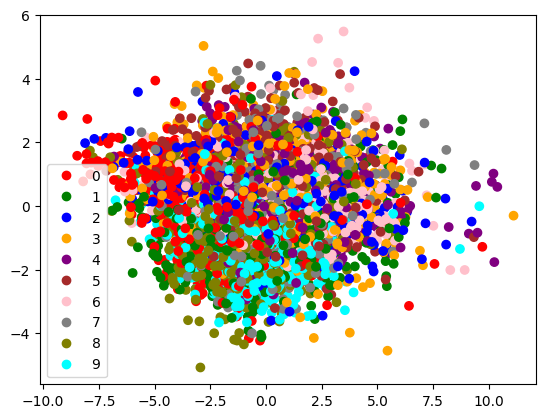

In [43]:
# Load Models
pca = PCA(n_components=2)
# best_fold = np.argmax(accuracy)
model = Model(z_dim=embed_size, strategy=sampling_strategy, input_channels=input_channels, input_dim=input_dim).to(DEVICE)
model.load_state_dict(torch.load(f"./weights/VAE/VAE_{1}_weights.pt"))

# Label, Embedding Matrices
size = len(test_dataset)
embedding = torch.zeros((size, embed_size))
y = torch.zeros(size)

with torch.no_grad():
  for i, (image, label) in tqdm(enumerate(test_loader)):
    # image = image.squeeze()
    image = image.to(DEVICE)
    label = label.to(torch.int32).to(DEVICE)

    z, _, _, _ = model.forward(image)
    embedding[i*batch_size:min((i+1)*batch_size, size)] = z
    y[i*batch_size:min((i+1)*batch_size, size)] = label

if embed_size != 2:
  embedding = pca.fit_transform(embedding)

colors = ['red','green','blue','orange','purple','brown','pink','gray','olive','cyan']
colours = ListedColormap(colors)
scatter = plt.scatter(embedding[:,0], embedding[:,1], c=y, cmap=colours)
plt.legend(*scatter.legend_elements())
plt.savefig("./latent.png", format="png")

In [ ]:
model.load_state_dict(torch.load(f"./weights/VAE/VAE_{best_fold}_weights.pt"))
classifier_network = FeedForwardClassifier(output_dim=num_classes, embed_size=embed_size).to(DEVICE)
classifier_network.load_state_dict(torch.load(f"./weights/classifier/classifier_{best_fold}_weights.pt"))

model.eval()
classifier_network.eval()

correct = 0
with torch.no_grad():
  for image, label in tqdm(test_loader):
    image = image.to(DEVICE)
    label = label.to(torch.int32).to(DEVICE)

    embedding, _, _, _ = model.forward(image)
    prediction = classifier_network.predict(embedding).to(torch.int32)

    correct += int(sum(prediction==label))
print()
print(f"Accuracy : {100*correct/len(test_loader.dataset):.2f}")